In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
import os
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import dask_image.imread
import numpy as np
from skimage import feature, morphology, img_as_float
from sklearn.decomposition import PCA 
import scipy.ndimage as ndi
from random import random
import sklearn
import cc3d
import pandas as pd
import seaborn as sns
import math

In [2]:
def get_vec(label, idx):
    pca = PCA()
    xl, yl, zl = np.where(label==idx)
    voxelsl = [v for v in zip(list(xl.astype(np.float32)), list(yl.astype(np.float32)), list(zl.astype(np.float32)))]
    pca.fit(voxelsl)
    return np.array([int(np.mean(xl)), int(np.mean(yl)), int(np.mean(zl))]), pca.components_[2]*100, pca.explained_variance_[2]

In [3]:
def get_vec_mito(label, idx):
    pca = PCA()
    xl, yl, zl = np.where(label==idx)
    voxelsl = [v for v in zip(list(xl.astype(np.float32)), list(yl.astype(np.float32)), list(zl.astype(np.float32)))]
    pca.fit(voxelsl)
    return np.array([int(np.mean(xl)), int(np.mean(yl)), int(np.mean(zl))]), pca.components_[0]*100

In [4]:
def angle(x,y):
    dot_xy = np.dot(x,y)
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    cos = dot_xy / (norm_x*norm_y)
    rad = np.arccos(cos)
    theta = rad * 180 /np.pi
    return theta

In [5]:
def compute_angle(x,y):
    return(min(angle(x,y), angle(-x, y)))

In [6]:
def compute_all_mito(df, df_la, labels_mito, labels_la):
    npu_mito, count_mito = np.unique(labels, return_counts=True)
    angles_m = [] #angle mean
    mito_nums=[] #mito number
    mito_V_pxs=[] #mito volume
    mito_V_pxs_mito=[]
    lamellar_no=[] #lamellar id 
    lamellar_v_pxs=[] #lamellar volume
    angles=[] # lamellar mito angle
    covs = [] # pc3 cov
    cov_vs = [] #pc3 cov/lamellar volume
    mito_num=0
    for i in range(1, len(npu_mito)):
        if count_mito[i]>1000:
            _, mito_vec = get_vec_mito(labels, npu_mito[i])
            cristaes = np.where(labels==npu_mito[i], labels_la, 0)
            npu, count = np.unique(cristaes, return_counts=True)   
            angles_temp = []
            mito_num=mito_num+1
            mito_V_pxs_mito.append(count_mito[i])
            if len(npu)==1:
                angles_m.append(None)
            else:
                for idx in range(1,len(npu)):
                    if count[idx]>1000:
                        _, vec, cov = get_vec(cristaes, npu[idx])
                        ang = compute_angle(vec, mito_vec)
                        angles_temp.append(ang)
                        mito_nums.append(mito_num)
                        mito_V_pxs.append(count_mito[i])
                        lamellar_v_pxs.append(count[idx])
                        angles.append(ang)
                        covs.append(cov)
                        cov_vs.append(cov/count[idx])
                print(angles_temp)
                angles_m.append(np.mean(angles_temp))
                lamellar_no = lamellar_no + list(range(1,len(angles_temp)+1))
    if len(df)==0:
        crop_num=1
    else:
        crop_num=int(list(df['crop_No'])[-1])+1

    df_temp = pd.DataFrame({'crop_No': [crop_num]*(len(angles_m)),
                            'mito_No' : list(range(1, mito_num+1)),
                 'mito_V_px' : mito_V_pxs_mito,
                'angles' : angles_m})
    print(len([crop_num]*(len(mito_nums))))
    print(len(mito_nums))
    print(len(mito_V_pxs))
    print(len(lamellar_no))
    print(len(angles))
    print(len(covs))
    print(len(cov_vs))
    df_la_temp= pd.DataFrame({'crop_No' :[crop_num]*(len(mito_nums)),
                         'mito_No' :mito_nums,
                         'mito_V_px' :mito_V_pxs,
                         'lamellar_No' :lamellar_no,
                         'lamellar_V_px' : lamellar_v_pxs,
                         'angles' :angles,
                         'lamellar_PC3cov' :covs,
                         'cov/V': cov_vs})
    return pd.concat([df, df_temp]).reset_index(drop=True), pd.concat([df_la, df_la_temp]).reset_index(drop=True)

In [7]:
# calculate control
df= pd.DataFrame({'crop_No' :[],
                  'mito_No' :[],
                 'mito_V_px' : [],
                'angles' : []})
df_la= pd.DataFrame({'crop_No' :[],
                     'mito_No' :[],
                     'mito_V_px' : [],
                     'lamellar_No' :[],
                     'lamellar_V_px' : [],
                     'angles' : [],
                     'lamellar_PC3cov' :[],
                     'cov/V':[]})
for idx in range(5):
    print(idx)
    filename_pattern = os.path.join(f'Z:/DeepLearningData/research_010_NIH3T3/shCtrl_003/annotations/cropped_00{idx+1}/devided_mito', '*.png')
    mito = dask_image.imread.imread(filename_pattern)
    mito_np = np.zeros(mito.shape, np.uint8)
    for i in range(len(mito)):
        mito_np[i] = (mito[i].compute()>0)*255
    connectivity = 6 
    labels = cc3d.connected_components(mito_np, connectivity = connectivity)
    filename_pattern_l = os.path.join(f'Z:/DeepLearningData/research_010_NIH3T3/shCtrl_003/annotations/cropped_00{idx+1}/merged_cristae_final/lamellar_with_postprocessing', '*.png')
    la = dask_image.imread.imread(filename_pattern_l)
    la_np = np.zeros(la.shape, np.uint8)
    for i in range(len(la)):
        la_np[i] = (la[i].compute()>0)*255
    diamond = ndi.generate_binary_structure(rank=3, connectivity=1)
    eroded = ndi.binary_erosion(la_np, diamond, iterations=1)
    labels_la = cc3d.connected_components(eroded, connectivity = connectivity)
    if labels.shape != labels_la:
        labels = labels[:, :labels_la.shape[1], :labels_la.shape[2]]
    df, df_la = compute_all_mito(df, df_la, labels, labels_la)
    
    

0


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


[48.37499314870493, 49.94609323590074, 53.86815456110133]
[74.59139502562245, 30.827855872626067]
[84.44763278113304]
[84.45911507571878]
[84.2979111162767]
[63.27617258253263, 40.360001492175805, 58.639199845459345, 63.997266587512534]
[74.9564127381584, 88.11824208181584]
[72.15931777241425, 67.14003237354873]
[81.96038326496276, 81.777560633396]
[83.84780242826366, 73.06170786641825]
[76.16525551182656, 76.98501742003766]
[82.05717118050366, 87.6156501682337]
[71.52024754357312]
[88.7845852566763]
[82.63734312091925, 83.73170340585418]
[63.08940979188512, 78.67769941770658]
[85.77005779489515, 68.623944074016, 88.4729267607523]
[82.01985749620664, 25.82723085205607]
[88.17491500160276, 86.40465271458078, 86.8860411220095]
[76.14358571098124]
[75.48527970702358]
[86.02751324033981]
[85.28847649633657, 84.9020992909199]
43
43
43
43
43
43
43
1


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


[72.89993585804592, 61.05039362914445]
[42.818794189265546, 47.27329691929955, 41.598918143031305, 40.32507321975091, 47.40967903916151, 49.42796398059893]
[58.75082791594636]
[75.80651711873256, 73.18370056849787, 50.5382900146771, 47.083521840521925]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[76.55982188306483, 75.92921101724808, 74.13041715467347]
[78.71918968298415]
[26.901135815257682, 26.46290610174325, 28.651867512980054, 25.758284120701706, 45.919120747441596, 45.510882120716225, 45.321301948951636]
[82.62226698695683]
[58.29993938818317, 68.07470704048721]
[50.09180541161763, 45.19200881063429, 67.04005479481748, 65.92220692729552]
[79.7678126971633, 79.85188649866944]
33
33
33
33
33
33
33
2


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


[84.08287049404424, 81.53892034953618, 58.286881919323285, 69.03416353463314, 72.22489790050287, 72.00890871338162, 50.20665540505723, 37.749883097721984, 27.31227384167464, 64.26096111787955, 26.04275284205741, 69.82886929932154, 82.66721008227532, 22.971183666871863, 40.36070454187611, 61.82591192380165, 43.79005375513464, 88.91090769981578, 85.02883125904687, 75.08317649157684, 74.27892823130387, 78.5635406996063, 47.05915041116957]
[69.98699993770961, 57.49698332209079, 80.50583895946825, 43.53314917380503, 54.18248906691982, 89.81387245906362, 47.06557799552403, 11.44192362367252, 43.81397684732082, 43.69956997984589]
[57.0249364267322, 62.866109870931226, 53.092059024264614, 80.40202082165979, 58.560657647378974, 83.67312303002579]
[69.28692507184171, 65.57589632233054, 89.77028014051896, 75.83058690179178, 88.80688002679084, 70.44630986411595]
[87.6119283800145, 37.64910932338074, 88.39971059923215, 31.118087370195234, 71.86875937577749, 87.57853771419175]
[82.9931455801516, 52.

C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[89.20906380737188, 82.40259130363415, 48.879723592380806, 41.77745127517764, 48.0361374630808, 78.893880461013]
[38.26395231909766, 39.22248113717675, 63.257747457874856, 35.8519607386544, 28.8364065780761, 49.167340696965816, 21.17725134689532, 23.064156977665338]
[56.78077864605183, 55.86768801245693, 34.56666414003446, 83.00585905117848, 83.32974923682936, 33.61440785366891, 41.7536122081456, 43.08745560743828, 38.675057562659696]
[73.11029483626837, 63.40553785541206, 87.80092324687143]
[86.01148069641114]
[72.77393776247635, 80.607543249525]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[35.47551798333011, 40.75624866610732, 44.957408194254725, 53.27700781218177, 53.87012649346796, 45.999041080232885, 56.80298427534332, 64.12372881917369, 62.50168189633154, 58.061234529018684, 45.93234592311754]
[71.31732694696622, 26.92615659259483, 62.686951185318506]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[67.44739630921018]
105
105
105
105
105
105
105
3


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


[85.73941275096473, 82.61022582490368, 6.917375705951931]
[40.91045541316476, 30.000536310133274]
[41.411300912916666]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[7.111476278558287, 66.14815023613673]
[74.92918909663025]
[72.44435416933963]
[82.52157999579501]
[81.94303425699361, 85.99483476897733, 80.69382712838461]
[36.65094446751545]
[40.18893333329226, 34.508481441402544, 29.7842027225792, 25.80256024638143, 27.214758501145667]
[52.98868173234352]
[86.23316836987847]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[69.16422361625047, 43.60318619579757]
[32.86920146003924, 34.52145299112765, 32.01025828154428]
[81.84829053592861, 36.7622826666514]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[39.337244407595236, 67.16429283743257, 28.30868853018991, 12.740514873062583, 24.878896680262525, 18.859598280877808, 23.137274395612415, 74.72931233358905, 33.54810108182647, 24.449664464179026]
[78.65736765833398, 82.55178667007822, 89.36786750771815, 47.50142925177374, 63.66823187674815]
[24.464452996857567, 72.68462986495865]
[81.73136683735845, 53.83472102341639]
[59.9796833787641]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[50.13500003462147, 15.005942403322745, 37.62827872694197]
[79.41042337281192]
[88.50730363056041, 36.42274577267014, 64.98083299973307]
[69.39189088726178]
[60.5752487696948]
[47.30076795807585, 50.23110039309222]
[25.061106783500335, 55.27082413281461, 37.60514730054893, 32.143189740695455]
[66.42803640953264, 62.80154630899209]
[43.81578665195743, 81.84897028960262]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[44.29374047349317]
[38.750795089009486, 23.97437316395785, 84.53723090280884]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[40.85924169429101]
[72.04119841498732, 66.75939121262068, 58.44117726488287]
[74.04576478412848, 36.6655165972666]
[31.760407240671874, 55.52963723749362]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[64.85932037834552]
[78.76179044229296, 85.26704843619626, 83.25301522987782, 84.86481979677616, 68.08344716262015]
[76.40239819688271]
[42.943479549576175, 54.842597955920205, 39.72713517434315]
[57.55878547056791]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[87.02067062475632]
[47.78290505516639]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


93
93
93
93
93
93
93
4


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


[79.59955804751148]
[66.20264896519821, 69.43469968853056]
[85.65691050860099]
[66.87598595817839, 59.863555035771014]
[81.41136109984048]
[77.65751905538049, 76.76794322510256, 47.17397456390412, 47.842056273677514, 38.16441064228793]
[84.28043665193759]
[76.6186724355328, 74.76403151062993]
[78.62160226688763, 66.54979476475263]
[58.3214354160726, 3.8959974663584016, 4.2651529683296685, 10.87358527467475, 20.724719016068217, 76.23517164647738]
[76.9895184874286, 86.2608703941171]
[72.42878005832247]
[79.18417829434634]
[77.6077816696666]
[60.1850134345563, 87.09741834797317]
[79.02612751144235]
[28.40581216791916, 79.12817235528709]
[74.42129904082749]
[82.0406240304105]
35
35
35
35
35
35
35


In [ ]:
# calculate shOPA1
df2= pd.DataFrame({'crop_No' :[],
                  'mito_No' :[],
                 'mito_V_px' : [],
                'angles' : []})
df2_la= pd.DataFrame({'crop_No' :[],
                     'mito_No' :[],
                     'mito_V_px' : [],
                     'lamellar_No' :[],
                     'lamellar_V_px' : [],
                     'angles' : [],
                     'lamellar_PC3cov' :[],
                     'cov/V':[]})
for idx in range(5):
    filename_pattern = os.path.join(f'Z://DeepLearningData/research_010_NIH3T3/shOPA1_003/annotations//cropped_00{idx+1}/devided_mito', '*.png')
    mito = dask_image.imread.imread(filename_pattern)
    mito_np = np.zeros(mito.shape, np.uint8)
    for i in range(len(mito)):
        mito_np[i] = (mito[i].compute()>0)*255
    connectivity = 6 
    labels = cc3d.connected_components(mito_np, connectivity = connectivity)
    filename_pattern_l = os.path.join(f'Z://DeepLearningData/research_010_NIH3T3/shOPA1_003/annotations//cropped_00{idx+1}/merged_cristae_final/lamellar_with_postprocessing', '*.png')
    la = dask_image.imread.imread(filename_pattern_l)
    la_np = np.zeros(la.shape, np.uint8)
    for i in range(len(la)):
        la_np[i] = (la[i].compute()>0)*255
    diamond = ndi.generate_binary_structure(rank=3, connectivity=1)
    eroded = ndi.binary_erosion(la_np, diamond, iterations=1)
    labels_la = cc3d.connected_components(eroded, connectivity = connectivity)
    df2, df2_la = compute_all_mito(df2, df2_la, labels, labels_la)

[55.08243614918314]
[86.52416774294561]
[83.37753444776394, 48.901958572569185]
[61.81239704530042, 52.69685683692348, 38.55876632980423]
[88.20758248314533]
[87.71072790466192]
[73.51223844815773]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[86.76245036185549]
[89.23757182426249]
[89.24038441522612]
[78.47899058470483, 49.60341132803458, 62.60240413467976]
[83.96622747414568]
[88.59073278192407, 84.49220910419808]
[83.604245211736]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[86.5968343198151]
[85.98436251221185]
[76.53236760126394]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[76.20179159892277]
[89.44275957178453]
[85.3825302852106]
[83.04586645136933]
[89.34901316675506]
[74.6709184162494]
[83.62438091449309]
[87.4538574212004]
[83.91913932919151]
[66.80291985275463]
[78.57849380982634]
[75.50977505156085]
[83.79449891990006]
[83.30975163271778]
[65.9887167760927]
[82.4601542189231]
[82.50272667018864]
[89.04949536497077]
[81.19596317496186]
[87.69550632743079]
[89.78426781862011]
[80.25835501520085]
[83.48367867228166]
[88.75758696982318]
[77.13430247870815, 55.03764108283593]
[88.08060011784615]
[85.66942039552133]
[42.89615832017467, 18.958849056443235]
[84.3319198250841]
[69.50179836747326]
[85.11221485520238]
[85.46415704531589]
[76.6268024946832]
[87.2870973274655]
[86.59011068396126]
[66.37497997010897]
[80.51346435288174, 85.21857135716255]
[44.044977298584755]
[79.97136645373295, 79.69927868187494]
[89.63484778281942]
[86.7608286325386]
[84.48471917113191]
[87.64819435445676]
[74.56923520298051, 58.90686342377556]
[88.42124294840089]
[88.59865489

C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[87.20178138381318]
[73.21441332786704]
[77.03252914213544, 59.002241924286935, 82.85870726789788]
[39.0473901021176]
[87.66564110701852]
[47.653046207497106]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[86.77213272936234]
[73.71925507664604]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[88.28029735142876]
[84.47938716944738]
[88.17750644972013]
[89.3334391743965, 86.98369601446835]
[89.67375444594381]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[67.77936385036614]
[84.87889358520297]
[89.45733283439905]
[77.07244687864022]
[63.10679118218933, 31.17381850293358]
[88.03615135667155]
[81.20063488076455]
[86.86435669270244]
[87.4040495388186, 63.99873569636513, 81.20646491931335]
[54.342877792039, 76.43977561175558]
[85.45418312254262]
[88.82702989480417]
[82.07580159845114]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[79.06187923654369]
[37.14425184685731, 64.00941934692094]
[87.05910400515947]
[86.11647576378003, 57.95006658228636]
[85.89514979340866]
[89.7799680131702]
[33.44697542462355, 86.44570350879754]
[76.00982179378825]
[88.97494717754478]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[87.33021834881856]
[59.31187076132319]
[88.25765577793307]
[73.22463831319064, 40.55955286997498]
[69.01820701965022, 87.08303648107388]
[89.55100606939767, 75.96972848496547]
[88.19087436792734, 75.89096222410475]
[89.87680854430552, 86.89729708951906]
[84.92256506398984]
[72.66542737176316]
[52.77071039563564]
[68.58729049566104]
[86.48916107891867]
[88.9728924468986]
[86.88105015645375]
[83.38425039936531]
[89.12270474355687]
[86.02277833839105]
[89.67927349158253]
[88.92967211178708]
[89.7377332293455]
[89.04518507675712]
[89.28334902227998]
157
157
157
157
157
157
157
[80.33188997645644]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[59.29688754477361]
[88.96944152203838]
[87.11368495991361]
[84.84474284144831, 88.94425012786317]
[81.02114566240964, 32.50820573799012, 80.410498958188, 15.978498244688247]
[76.87314938927929]
[72.02993443907846]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[75.60654179933948, 68.33125242643908]
[58.606631143692624, 46.50407099128076, 39.268096575576486]
[87.01403339241723]
[66.79154740379374]
[76.03072722164563]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[80.6868719770217]
[60.63959972400186]
[71.76837465568791, 80.99563429671518]
[89.01487339693946]
[81.34014363457881]
[67.1621291752742, 77.95568307156073]
[80.9250111968886]
[66.64003536723753, 63.863751422799794]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[46.70957629270966]
[87.70442695727013]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[82.34054811768391]
[88.03069636005786]
[]


C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Neurobiology\Anaconda3\envs\philow_data_manuscript\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[80.58327246380102]
[72.80613882232318, 73.41898024111174]


In [17]:
df2_la['gene'] = ['shOPA1']*len(df2_la)
df_la['gene'] = ['shCtrl']*len(df_la)


In [18]:
df2['gene'] = ['shOPA1']*len(df2)
df['gene'] = ['shCtrl']*len(df)

In [19]:
df.to_csv('angles_ctrl.csv', index=False)
df2.to_csv('angles_opa1.csv', index=False)
df_la.to_csv('lame_ctrl.csv', index=False)
df2_la.to_csv('lame_opa1.csv', index=False)

In [20]:
df = pd.read_csv('angles_ctrl.csv')
df2 = pd.read_csv('angles_opa1.csv')
df_la = pd.read_csv('lame_ctrl.csv')
df2_la = pd.read_csv('lame_opa1.csv')

In [21]:
df_c = pd.concat([df,df2])
df_c

,crop_No,mito_No,mito_V_px,angles,gene
0,1.0,1.0,545648.0,50.729747,shCtrl
1,1.0,2.0,457678.0,52.709625,shCtrl
2,1.0,3.0,449917.0,84.447633,shCtrl
3,1.0,4.0,295946.0,84.459115,shCtrl
4,1.0,5.0,395491.0,84.297911,shCtrl
...,...,...,...,...,...
319,5.0,46.0,448138.0,89.729640,shOPA1
320,5.0,47.0,153030.0,86.130683,shOPA1
321,5.0,48.0,19869.0,NaN,shOPA1
322,5.0,49.0,477734.0,65.951480,shOPA1


In [22]:
df_la_c = pd.concat([df_la,df2_la])
df_la_c

,crop_No,mito_No,mito_V_px,lamellar_No,lamellar_V_px,angles,lamellar_PC3cov,cov/V,gene
0,1.0,1.0,545648.0,1.0,4614.0,48.374993,1.411042,0.000306,shCtrl
1,1.0,1.0,545648.0,2.0,24247.0,49.946093,81.734532,0.003371,shCtrl
2,1.0,1.0,545648.0,3.0,5097.0,53.868155,3.249163,0.000637,shCtrl
3,1.0,2.0,457678.0,1.0,29473.0,74.591395,53.403300,0.001812,shCtrl
4,1.0,2.0,457678.0,2.0,1375.0,30.827856,1.940838,0.001412,shCtrl
...,...,...,...,...,...,...,...,...,...
364,5.0,43.0,396360.0,1.0,26697.0,81.868623,79.467174,0.002977,shOPA1
365,5.0,44.0,148214.0,1.0,2651.0,69.630160,3.504601,0.001322,shOPA1
366,5.0,46.0,448138.0,1.0,13440.0,89.729640,60.048976,0.004468,shOPA1
367,5.0,47.0,153030.0,1.0,7453.0,86.130683,87.862452,0.011789,shOPA1


In [23]:
df_temp = df_la_c[df_la_c['gene']=='shCtrl']
xs = []
ys = []
for i in range(len(df_temp)):
    theta = math.radians(df_temp['angles'][i])
    x = math.cos(theta)/df_temp['lamellar_PC3cov'][i]
    y = math.sin(theta)/df_temp['lamellar_PC3cov'][i]
    xs.append(x)
    ys.append(y)
df_temp = df_la_c[df_la_c['gene']=='shOPA1']
xs2 = []
ys2 = []
for i in range(len(df_temp)):
    theta = math.radians(df_temp['angles'][i])
    x = math.cos(theta)/df_temp['lamellar_PC3cov'][i]
    y = math.sin(theta)/df_temp['lamellar_PC3cov'][i]
    xs2.append(x)
    ys2.append(y)

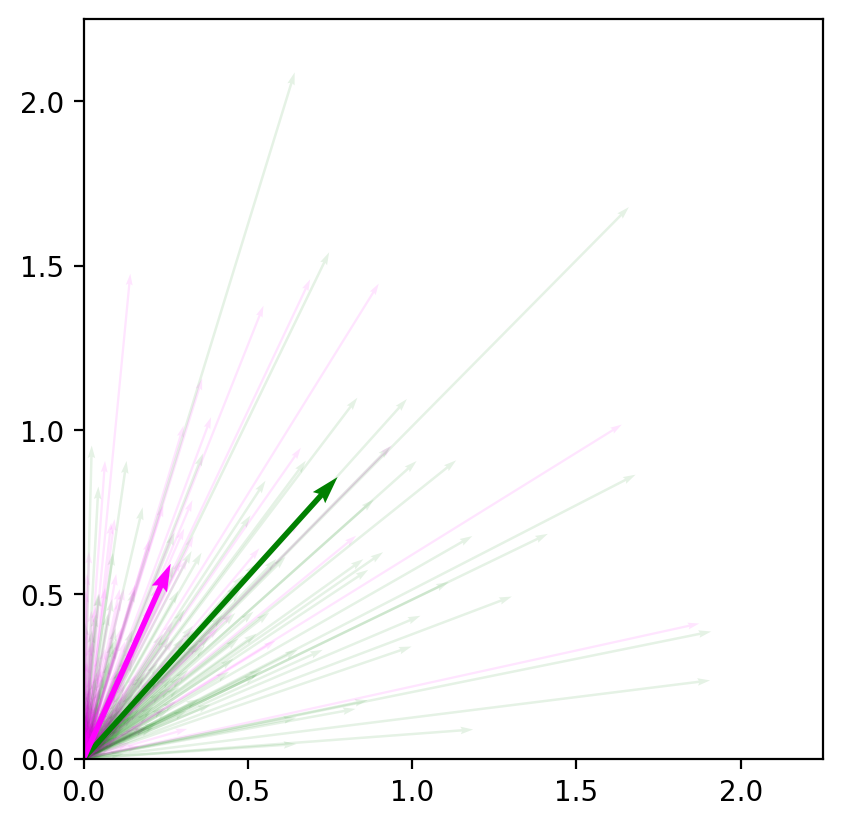

In [24]:
plt.quiver([0]*len(xs), [0]*len(xs), xs, ys, angles='xy', scale_units='xy', scale=1, color='green', alpha=0.1)
plt.quiver([0]*len(xs2), [0]*len(xs2), xs2, ys2, angles='xy', scale_units='xy', scale=1, color='magenta', alpha=0.1)
plt.quiver(sum(xs)/len(xs), sum(ys)/len(ys), angles='xy', scale_units='xy', scale=0.25, color='green')
plt.quiver(sum(xs2)/len(xs2), sum(ys2)/len(ys2), angles='xy', scale_units='xy', scale=0.25, color='magenta')
plt.axis('square')
plt.xlim(0,2.25)
plt.ylim(0,2.25)
plt.xticks( np.arange(0, 2.5, 0.5))
plt.yticks( np.arange(0, 2.5, 0.5))
plt.savefig("quiver.svg", format="svg")

In [28]:
np.average(df_la["angles"])

59.56955094513904

In [29]:
np.average(df2_la["angles"])

74.44393233131233